# Objective
Predict the energy throughput ratio of each frequency regulartion for each 5 minute interval during Feb 21-28.
1. Regulation throughput ratio = abs(average power) / regulation capacity award. A resource that averages 5MW (discharging) during an hour with a market award of 10MW Regulation Raise would have a 50% Raise Regulation Throughput Ratio. (5MW/10MW=50%)

#### Ratio implications ####
- If the throughput ratio is high, then the energy intensity of providing regulation is high
- A traditional energy award is a throughput ratio of 1. 

#### Tasks ####
1. Clean and prepare data
<p> Eliminate any obvious outlier frequency values</p>
<p> transform the 1 second frequency data in to 2 new columns. 5 minute average and 5 minute median</p>
2. Analyze data and summarize key observations
3. Prediction model
<p> why did you choose this model </p>
<p> Did you consider any other methods</p>
<p> predict regulation raise and lower throughput ratios for the last week in Feb</p>
<p> forecast in csv and include summary visuals</p>
<p> list the features and why you selected them</p>
<p> attach code</p>
<p> how would you describe the effectiveness</p>
<p> what other data would you want?</p>

## Imports

In [26]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import timeseries_helpers as th
import numpy as np
sns.set()

## 1. Clean and prepare the data
What does the data look like?

In [27]:
freq_df = pd.read_csv('frequency.csv')
freq_df.head(2)

,Timestamp (GMT),Frequency (Hz)
0,1514728800001,50.0
1,1514728801001,50.0


# Taks 1A eliminate any obvious outliers. 
Plan: 
1. Plot the frequency over time and look for outliers
2. Remove data points that are more than 4 standard deviations away

In [28]:
freq_df['utc_date'] = pd.to_datetime(freq_df['Timestamp (GMT)'], unit='ms')
freq_df.index = freq_df.utc_date
freq_df.index = freq_df.index.tz_localize('UTC')
freq_df.index = freq_df.index.tz_convert('Australia/Sydney')

(49.7, 50.5)

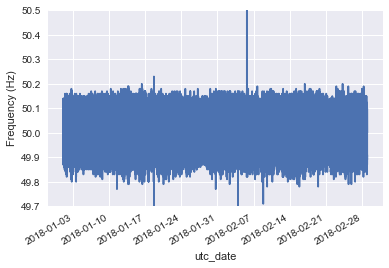

In [29]:
axs = freq_df['Frequency (Hz)'].plot()
axs.set_ylabel('Frequency (Hz)')
axs.set_ylim(49.7, 50.5)

It does not look like the variance is changing over time so no need to account for heteroskedacity

Text(0,0.5,'Number of occurrences')

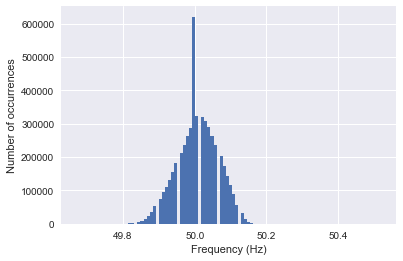

In [30]:
ax2 = freq_df['Frequency (Hz)'].plot(kind='hist', bins=100)
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Number of occurrences')

It is interesting that there is one bin in the histogram that has nearly double the number of occurrences. Perhaps it's a default value in the frequency measurement system. I would ask for more information to determine if that value is physically meaningful.

In [31]:
freq_sd = freq_df['Frequency (Hz)'].std()
freq_mean = freq_df['Frequency (Hz)'].mean()

(49.7, 50.5)

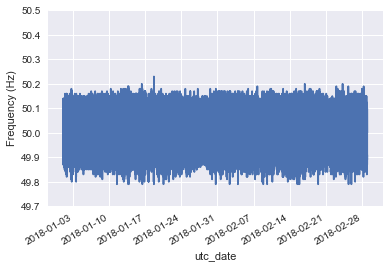

In [32]:
freq_df = freq_df.loc[((freq_mean - 4*freq_sd) < freq_df['Frequency (Hz)']) &
                              (freq_df['Frequency (Hz)'] < (freq_mean + 4*freq_sd))]
axs = freq_df['Frequency (Hz)'].plot()
axs.set_ylabel('Frequency (Hz)')
axs.set_ylim(49.7, 50.5)

### Task 1B:
Convert 1 second frequnecy data into 5 minute average values and 5 minute median values

In [33]:
five_min_mean = freq_df.resample('5T').mean()
del five_min_mean['Timestamp (GMT)']

In [34]:
def mean_resampler(array_like):
    return np.median(array_like)

In [35]:
five_min_median = freq_df.resample('5T').apply(mean_resampler)
del five_min_median['Timestamp (GMT)']

In [36]:
five_min_mean = five_min_mean.\
                    rename(columns={'Frequency (Hz)': '5_min_mean_freq_hz'})
five_min_median = five_min_median.\
                rename(columns={'Frequency (Hz)': '5_min_median_freq_hz'})

In [37]:
five_min_mean.columns

Index(['5_min_mean_freq_hz'], dtype='object')

In [38]:
downsampled_df = five_min_mean.join(five_min_median)
downsampled_df.tail()

,5_min_mean_freq_hz,5_min_median_freq_hz
utc_date,,
2018-03-01 00:35:00+11:00,50.034233,50.029999
2018-03-01 00:40:00+11:00,50.026300,50.025000
2018-03-01 00:45:00+11:00,50.015733,50.020000
2018-03-01 00:50:00+11:00,50.039000,50.040001
2018-03-01 00:55:00+11:00,49.991300,49.990002


## Analyze the data set

In [39]:
ratio_df = pd.read_csv('throughput_ratio.csv')
ratio_df.head(2)

,Interval Ending (AEST),Raise Throughput Ratio,Lower Throughput Ratio
0,1/1/18 0:05,NaN,NaN
1,1/1/18 0:10,0.224593,NaN


In [40]:
generation_df = pd.read_csv('wind_generation.csv')
generation_df.head(2)

,Interval Ending (AEST),BLUFF1,CLEMGPWF,HALLWF1,HALLWF2,HDWF1,HDWF2,HDWF3,LKBONNY2,LKBONNY3,NBHWF1,SNOWNTH1,SNOWSTH1,SNOWTWN1,TRLWF,WATERLWF
0,1/1/18 0:05,13.1,2.95344,10.74,10.54,24.4,13.1,17.7,51.98349,9.88050,21.2,16.1,9.5,14.87030,12.15719,12.4
1,1/1/18 0:10,11.9,3.24158,13.01,10.33,22.2,13.9,17.9,42.13140,10.27125,21.7,14.9,8.6,13.64382,11.68275,11.9


It appears that the generation data and the throughput ratio awards have the same time axis, it makes sense to join the data.

In [41]:
df = ratio_df.merge(generation_df, how='right', on='Interval Ending (AEST)')
df['Interval Ending (AEST)'] = df['Interval Ending (AEST)'].\
                                apply(lambda x: datetime.datetime.strptime(x, '%m/%d/%y %H:%M'))

In [42]:
df.index = df['Interval Ending (AEST)']

In [43]:
df.index = df.index.tz_localize('Australia/Sydney')

In [44]:
df = df.join(downsampled_df)

Sample the first two days in January to get a close look at what is going on

In [45]:
df.tail(2)

,Interval Ending (AEST),Raise Throughput Ratio,Lower Throughput Ratio,BLUFF1,CLEMGPWF,HALLWF1,HALLWF2,HDWF1,HDWF2,HDWF3,LKBONNY2,LKBONNY3,NBHWF1,SNOWNTH1,SNOWSTH1,SNOWTWN1,TRLWF,WATERLWF,5_min_mean_freq_hz,5_min_median_freq_hz
Interval Ending (AEST),,,,,,,,,,,,,,,,,,,,
2018-02-28 12:55:00+00:00,2018-02-28 23:55:00,NaN,NaN,2.9,12.89427,21.35,13.88,27.9,25.6,32.9,19.78754,3.85172,45.7,110.9,62.7,77.25018,11.45357,6.7,50.032133,50.029999
2018-02-28 13:00:00+00:00,2018-03-01 00:00:00,NaN,NaN,2.9,11.38153,21.19,12.14,27.2,26.0,33.6,17.02452,3.51679,48.5,107.4,62.7,77.81842,12.89427,8.5,50.030400,50.029999


In [46]:
sample = df.loc[df['Interval Ending (AEST)'] < datetime.date(2018, 1, 3)]

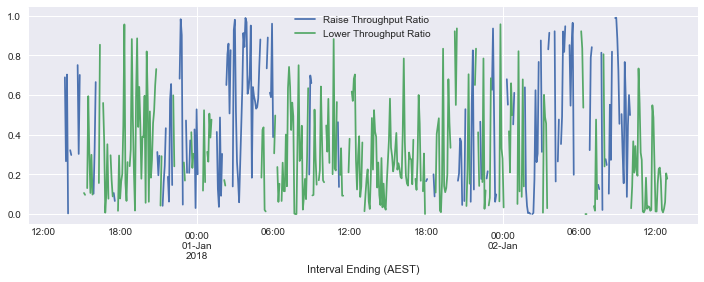

In [47]:
sample[['Raise Throughput Ratio', 'Lower Throughput Ratio']].plot(figsize=(12, 4))

In [48]:
sample[]

SyntaxError: invalid syntax (<ipython-input-48-9ee7936fa7c5>, line 1)

In [ ]:
sample['5_min_mean_freq_hz'].plot(figsize=(12,4))

#### Part 2a: Observations
- The frequency data had holes for several values of frequency. This could be caused by a firmware issue. The impact to the model is likely small since the data is being low-pass filtered; but, it could have implications for the battery hardware
- It looks like there is a clear increase in wind power in the evenings starting at 5pm. Which is followed by more lower throughput ratio
- The periodicity of the data is approximately one day
- The signal that we are trying to predict appears to be stationary. Meaning that it is not tredning up or down. We can set the ARIMA d=0

## Model


The benefit of this model is that the model has 

Candidate models:
- Linear regression
- 

Plan:
- use model
- evaluate results on second to last week

I will merge the raise throughput ratio and lower throughput ratio into one column where the lower throughput ratio is a negative value. This will make predictions a little easier

### First part of the pipeline: SVM multinomial classifier to determine if it's raise, lower, or hold

In [51]:
def condense_ratio(row):
    if (np.isnan(row['Raise Throughput Ratio'])) & (np.isnan(row['Lower Throughput Ratio'])):
        result = 0
    elif np.isnan(row['Raise Throughput Ratio']):
        result = -1
    else:
        result = 1
    return result

In [52]:
df['output'] = df.apply(condense_ratio, axis=1)

In [53]:
df['output'].value_counts()

 0    8238
-1    5113
 1    3641
Name: output, dtype: int64

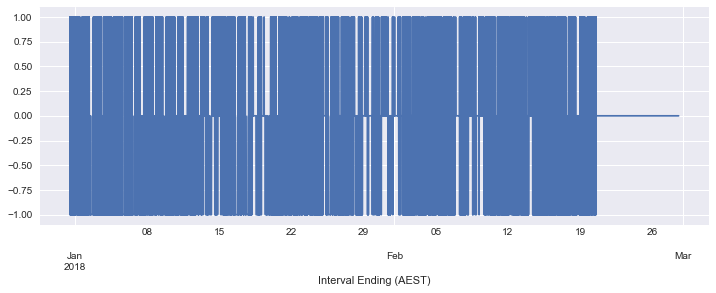

In [54]:
df.output.plot(figsize=(12,4))

In [55]:
model_df = df.drop(['Raise Throughput Ratio', 'Lower Throughput Ratio'],
                  axis=1)

In [56]:
model_df['hour'] = model_df['Interval Ending (AEST)'].apply(lambda x: x.hour)
model_df = model_df.drop(['Interval Ending (AEST)'], axis=1)

#### Add one-hot columns for the hour

In [69]:
import dateutil.parser

In [78]:
train_df = model_df.loc[model_df.index < dateutil.parser.parse('2018-02-01')]

cv_df = model_df.loc[(model_df.index > dateutil.parser.parse('2018-02-01')) &
                     (model_df.index < dateutil.parser.parse('2018-02-10'))
                    ]
test_df = model_df.loc[(model_df.index > dateutil.parser.parse('2018-02-10')) &
                       (model_df.index < dateutil.parser.parse('2018-02-20'))]

(9059, 19)

In [81]:
train_df.columns

Index(['BLUFF1', 'CLEMGPWF', 'HALLWF1', 'HALLWF2', 'HDWF1', 'HDWF2', 'HDWF3',
       'LKBONNY2', 'LKBONNY3', 'NBHWF1', 'SNOWNTH1', 'SNOWSTH1', 'SNOWTWN1',
       'TRLWF', 'WATERLWF', '5_min_mean_freq_hz', '5_min_median_freq_hz',
       'output', 'hour'],
      dtype='object')

## Model

In [176]:
from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error
from sklearn.model_selection import learning_curve, GridSearchCV

### Helpers

In [103]:
def ts_learning_curve(clf):

In [95]:
def plot_feature_importance(clf, x):
    feature_importance = clf.feature_importances_
    # make importances relative to max importance
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.subplot(1, 2, 2)
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, x.columns[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    plt.show()    

### Gradient Boosted

In [175]:
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
X_train = train_df.drop(['output'], axis=1)
X_test = cv_df.drop(['output'], axis=1)
y_train = train_df['output']
y_test = cv_df['output']

In [173]:
gbr = GradientBoostingRegressor(n_estimators=100,
                                learning_rate=0.1,
                                max_depth=1,
                                random_state=42,
                                loss='ls')
gbr_model = gbr.fit(X_train, y_train)

In [174]:
mean_squared_error(y_test, gbr.predict(X_test))

0.07972533221650727

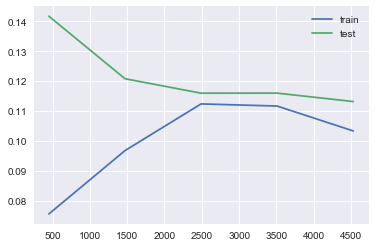

In [222]:
train_sizes, train_scores, test_scores =learning_curve(gbr, 
                                                       X_train, 
                                                       y_train, 
                                                       cv=2, 
                                                       scoring=make_scorer(mean_squared_error))

plt.plot(train_sizes, train_scores.mean(axis=1), label='train')
plt.plot(train_sizes, test_scores.mean(axis=1), label='test')
plt.legend()

Based on the learning curve, we are under-fitting. We can afford to add new features

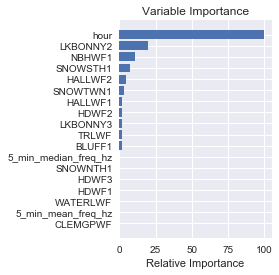

In [96]:
plot_feature_importance(gbr_model, X_train)

In [241]:
gbr_mae = GradientBoostingRegressor(n_estimators=100,
                                learning_rate=0.1,
                                max_depth=1,
                                random_state=42,
                                loss='ls', criterion='mae')
gbr_mae_model = gbr.fit(X_train, y_train)
mean_squared_error(y_test, gbr_mae_model.predict(X_test))

0.07972533221650727

In [186]:
param_grid = {'n_estimators':[100, 200, 300],
              'max_depth': [1,3,5]}
grid_search = GridSearchCV(gbr, 
             param_grid=param_grid, 
             scoring ='neg_mean_absolute_error',
             cv=2)

In [187]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=2, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=1, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100, 200, 300], 'max_depth': [1, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

In [189]:
print(grid_search.best_params_, grid_search.best_score_)

{'max_depth': 1, 'n_estimators': 100} -0.24262238284556384


Clearly time is a very important factor. Use fbprophet to create  fit daily variation with a Fourier time series

### Gradient boosted with seasonality model

In [123]:
from fbprophet import Prophet

In [210]:
model = Prophet(changepoints=None, 
                yearly_seasonality=False, 
                weekly_seasonality=False,
                daily_seasonality=True,
                seasonality_prior_scale=10,
                uncertainty_samples=10)

In [211]:
prophet_df = df.drop(['Raise Throughput Ratio', 'Lower Throughput Ratio'],
                  axis=1)
prophet_df = prophet_df[['Interval Ending (AEST)', 'output']]
prophet_df = prophet_df.rename({'Interval Ending (AEST)': 'ds',
                                'output': 'y'}, axis=1).reset_index()
prophet_df = prophet_df.drop(['Interval Ending (AEST)'], axis=1)
prophet_df = prophet_df.loc[prophet_df.ds < dateutil.parser.parse('2018-02-21')]
prophet_df.tail(2)

,ds,y
14685,2018-02-20 23:50:00,0.000000
14686,2018-02-20 23:55:00,0.274953


In [212]:
fb_model = model.fit(prophet_df)

/Users/isachsquintana/Documents/markets_challenge/v3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [145]:
daily_trend = fb_model.predict(prophet_df)

In [152]:
daily_trend.index = daily_trend.ds.dt.tz_localize('Australia/Sydney')
daily_trend.index = daily_trend.index.tz_convert('UTC')

In [163]:
train_df_fb = pd.concat([daily_trend['yhat'], train_df], join='inner', axis=1)
cv_df_fb = pd.concat([daily_trend['yhat'], cv_df], join='inner', axis=1)

In [164]:
X_train = train_df_fb.drop(['output'], axis=1)
X_test = cv_df_fb.drop(['output'], axis=1)
y_train = train_df['output']
y_test = cv_df['output']

In [165]:
gbr_fb_model = gbr.fit(X_train, y_train)

In [166]:
X_test.shape

(2591, 19)

In [167]:
y_test.shape

(2591,)

In [168]:
mean_squared_error(y_test, gbr.predict(X_test))

0.0809616860819499

In [171]:
mean_absolute_error(y_test, gbr.predict(X_test))

0.197470237372459

Interesting that adding periodicity to the model does not add much.

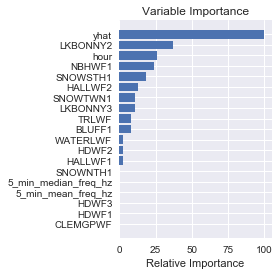

In [169]:
plot_feature_importance(gbr_model, X_train)

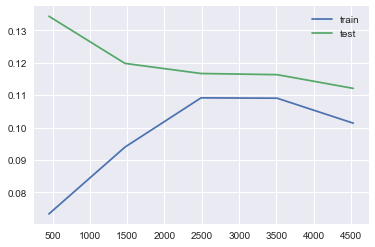

In [170]:
train_sizes, train_scores, test_scores =learning_curve(gbr, 
                                                       X_train, 
                                                       y_train, 
                                                       cv=2, 
                                                       scoring=make_scorer(mean_squared_error))
plt.plot(train_sizes, train_scores.mean(axis=1), label='train')
plt.plot(train_sizes, test_scores.mean(axis=1), label='test')
plt.legend()

### First degree derivative 
Since we are acting in response to a rapidly changing output. Take the the derivative of each of the features (except hour) as a factor for the model.

In [215]:
first_dt_x = model_df.drop(['output', 'hour'], axis=1)
first_dt_x = first_dt_x.diff()
second_dt_x = first_dt_x.diff()
dt_model = model_df.join(first_dt_x, rsuffix = '_dt', how='left')
dt_model = dt_model.join(second_dt_x, rsuffix = '_dt2', how='left')
dt_model.head()

,BLUFF1,CLEMGPWF,HALLWF1,HALLWF2,HDWF1,HDWF2,HDWF3,LKBONNY2,LKBONNY3,NBHWF1,...,LKBONNY2_dt2,LKBONNY3_dt2,NBHWF1_dt2,SNOWNTH1_dt2,SNOWSTH1_dt2,SNOWTWN1_dt2,TRLWF_dt2,WATERLWF_dt2,5_min_mean_freq_hz_dt2,5_min_median_freq_hz_dt2
Interval Ending (AEST),,,,,,,,,,,,,,,,,,,,,
2017-12-31 13:05:00+00:00,13.1,2.95344,10.74,10.54,24.4,13.1,17.7,51.98349,9.88050,21.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-31 13:10:00+00:00,11.9,3.24158,13.01,10.33,22.2,13.9,17.9,42.13140,10.27125,21.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-31 13:15:00+00:00,14.3,2.44919,13.60,10.63,22.2,15.6,16.6,32.53022,13.22982,21.5,...,0.25091,2.56782,-0.7,-0.3,-0.3,0.01694,-0.26798,1.9,0.0,0.0
2017-12-31 13:20:00+00:00,15.2,2.44919,12.79,9.87,21.8,15.6,17.9,33.10520,12.05756,20.8,...,10.17616,-4.13083,-0.5,1.1,-0.2,-0.22776,1.29505,-2.1,0.0,0.0
2017-12-31 13:25:00+00:00,15.6,3.74582,11.58,8.51,19.3,17.9,17.6,33.79725,14.23461,19.4,...,0.11707,3.34931,-0.7,-1.2,0.8,1.98123,-0.58612,0.8,0.0,0.0


In [216]:
train_dt = dt_model.loc[dt_model.index < dateutil.parser.parse('2018-02-01')]
train_dt = train_dt.iloc[1:]
cv_dt = dt_model.loc[(dt_model.index > dateutil.parser.parse('2018-02-01')) &
                     (dt_model.index < dateutil.parser.parse('2018-02-10'))
                    ]
test_dt = dt_model.loc[(dt_model.index > dateutil.parser.parse('2018-02-10')) &
                       (dt_model.index < dateutil.parser.parse('2018-02-20'))]

In [217]:
X_train_dt = train_dt.drop(['output'], axis=1)
X_test_dt = cv_dt.drop(['output'], axis=1)
y_train_dt = train_dt['output']
y_test_dt = cv_dt['output']

In [218]:
gbr_dt = gbr.fit(X_train_dt, y_train_dt)

In [219]:
mean_squared_error(y_test_dt, gbr_dt.predict(X_test_dt))

0.07918414432507055

In [220]:
mean_absolute_error(y_test_dt, gbr_dt.predict(X_test_dt))

0.19341828041096396

In [243]:
gbr_mae_model = gbr_mae.fit(X_train_dt, y_train_dt)
mean_squared_error(y_test_dt, gbr_mae_model.predict(X_test_dt))

0.07598884400349232

In [244]:
mean_absolute_error(y_test_dt, gbr_mae_model.predict(X_test_dt))

0.14376354812220948

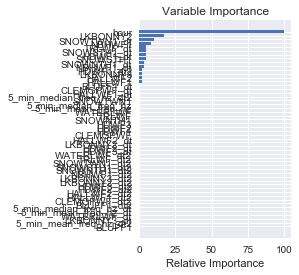

In [221]:
plot_feature_importance(gbr_dt, X_train_dt)

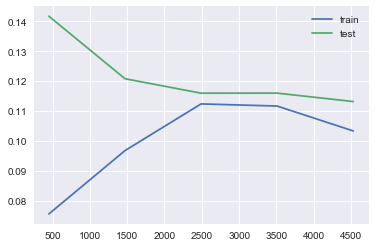

In [223]:
train_sizes, train_scores, test_scores =learning_curve(gbr_dt, 
                                                       X_train, 
                                                       y_train, 
                                                       cv=2, 
                                                       scoring=make_scorer(mean_absolute_error))

plt.plot(train_sizes, train_scores.mean(axis=1), label='train')
plt.plot(train_sizes, test_scores.mean(axis=1), label='test')
plt.legend()

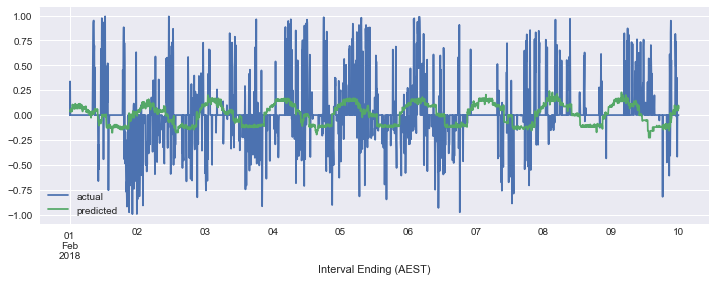

In [231]:
pd.DataFrame(index=cv_df.index, 
             data={'predicted': gbr_dt.predict(X_test_dt),
                     'actual': y_test_dt}).plot(figsize=(12,4))

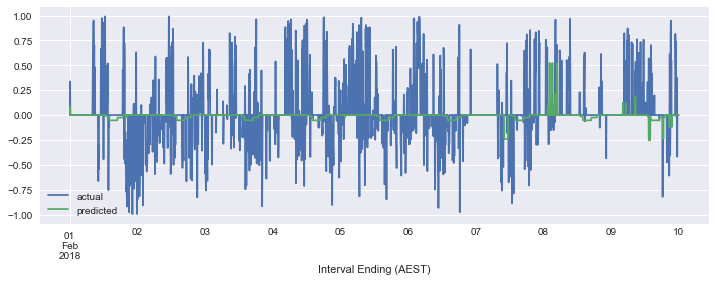

In [245]:
pd.DataFrame(index=cv_df.index, 
             data={'predicted': gbr_mae.predict(X_test_dt),
                     'actual': y_test_dt}).plot(figsize=(12,4))

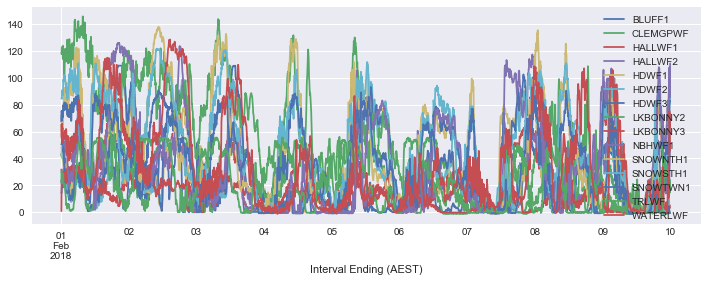

In [233]:
cv_df[cv_df.columns[:-4]].plot(figsize=(12,4))

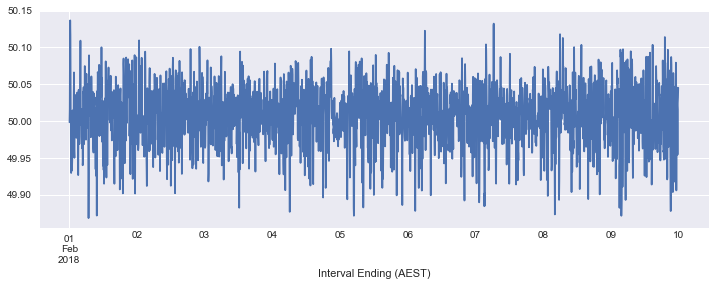

In [237]:
cv_df[cv_df.columns[-4]].plot(figsize=(12,4))